In [1]:


from __future__ import (division, unicode_literals, absolute_import,
                        print_function)

from ema_workbench import (Model, ScalarOutcome, TimeSeriesOutcome, perform_experiments,
                           RealParameter, CategoricalParameter, IntegerParameter, ema_logging)

from ema_workbench.connectors.vensim import VensimModel

import pandas as pd
import math
import numpy as np

c:\Users\pkane\.conda\envs\prj-lmr-scistack\lib\site-packages\ema_workbench\em_framework\evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
c:\Users\pkane\.conda\envs\prj-lmr-scistack\lib\site-packages\ema_workbench\connectors\__init__.py:27: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)


In [2]:
def row_writer(data, policy_name, start, max_by, max_value, interpolate=True, sub_1="", sub_2="", sub_3=""):
    target_row = (data['Policy']==policy_name) & (data['Subscript 1']==sub_1) & (data['Subscript 2']==sub_2) & (data['Subscript 3']==sub_3)

    data.loc[target_row, "2020":"2050"]=(max_value/100)*np.concatenate((np.zeros(start-2020),[i/(max_by) for i in list(range(0, min(max_by, 2050-start)))],np.ones(max(31-start-max_by+2020, 0))))


In [12]:
def policy_writer(**kwargs):
    policies = pd.DataFrame(columns=['policy', 'sub_1', 'sub_2', 'sub_3', 'start', 'max_by', 'max_value'])
    for key, value in kwargs.items():
        ids=key.split('__')
        if(((policies['policy']==ids[0]) & 
            (policies['sub_1']==ids[1]) & 
            (policies['sub_2']==ids[2]) &
            (policies['sub_3']==ids[3])).any()==False):
            policies.loc[len(policies.index)] = [ids[0], ids[1], ids[2], ids[3], 0, 0, 0]
        
        
        if(ids[-1]=='start'):
            policies.loc[((policies['policy']==ids[0]) & 
            (policies['sub_1']==ids[1]) & 
            (policies['sub_2']==ids[2]) &
            (policies['sub_3']==ids[3])), 'start']=value
        elif(ids[-1]=='maxby'):
            policies.loc[((policies['policy']==ids[0]) & 
            (policies['sub_1']==ids[1]) & 
            (policies['sub_2']==ids[2]) &
            (policies['sub_3']==ids[3])), 'max_by']=value
        elif(ids[-1]=='maxval'):
            policies.loc[((policies['policy']==ids[0]) & 
            (policies['sub_1']==ids[1]) & 
            (policies['sub_2']==ids[2]) &
            (policies['sub_3']==ids[3])), 'max_value']=value
    print(policies)
    read_data = pd.read_csv('FoPITY-1-default.csv',
        keep_default_na=False)
    for index, policy in policies.iterrows():
        row_writer(data=read_data, 
                   policy_name=policy['policy'].replace('_', ' '), 
                   start=policy['start'],
                   max_by=policy['max_by'],
                   max_value=policy['max_value'],
                   sub_1=policy['sub_1'].replace('_', ' '),
                   sub_2=policy['sub_2'].replace('_', ' '),
                   sub_3=policy['sub_3'].replace('_', ' ')
                   )
    read_data.to_csv('model\\eps-louisiana-3.4.3.3\\InputData\\plcy-schd\\FoPITY\\FoPITY-1.csv',
                     index=False)
    
    
def run_inner_model():
    wd = 'model\\eps-louisiana-3.4.3.3'
    innerModel = VensimModel("simpleModel", wd=wd,
                              model_file='EPS CAP.vpmx')
    innerModel.uncertainties = [RealParameter('xdata', 0, 1)]

    innerModel.outcomes = [TimeSeriesOutcome('Total CO2e Emissions'),
                           TimeSeriesOutcome('BAU Total CO2e Emissions'),
                           TimeSeriesOutcome('Output Social Benefits from Emissions Reduction'),
                           TimeSeriesOutcome('Total Change In CapEx and OpEx'),
                           TimeSeriesOutcome('Output Change in Domestic Jobs'),
                           TimeSeriesOutcome('Output Change in GDP')
                           ]

    inner_results = perform_experiments(innerModel, 1)

    inner_experiments, inner_outcomes = inner_results

    actual_outcomes = {'Emissions':np.mean(inner_outcomes['Total CO2e Emissions'][0][0:15])/907185000000,
                      'Cobenefits': np.mean(inner_outcomes['Output Social Benefits from Emissions Reduction'][0][0:15]),
                      'Cost':np.mean(inner_outcomes['Total Change In CapEx and OpEx'][0][0:15])/1000000000}
    print(actual_outcomes)

    return actual_outcomes

def policy_model(**policies):
    print("Running")
    policy_writer(**policies)
    return run_inner_model()

In [13]:
import rhodium as rhodium

rhodium_model = rhodium.Model(policy_model)
rhodium_model.parameters = [rhodium.Parameter('elec_renewable_portfolio_standards________maxval'),
                            rhodium.Parameter('elec_renewable_portfolio_standards________maxby'),
                            rhodium.Parameter('elec_renewable_portfolio_standards________start'),
                            rhodium.Parameter('hydgn_shift_production_pathways________start'),
                            rhodium.Parameter('hydgn_shift_production_pathways________maxby'),
                            rhodium.Parameter('hydgn_shift_production_pathways________maxval'),
                            rhodium.Parameter('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__electricity_if____start'),
                            rhodium.Parameter('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__electricity_if____maxby'),
                            rhodium.Parameter('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__electricity_if____maxval'),
                            rhodium.Parameter('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__hydrogen_if____start'),
                            rhodium.Parameter('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__hyrdogen_if____maxby'),
                            rhodium.Parameter('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__hydrogen_if____maxval'),
                            rhodium.Parameter('indst_low_temp_fuel_type_shifting__refined_petroleum_and_coke_19______start'),
                            rhodium.Parameter('indst_low_temp_fuel_type_shifting__refined_petroleum_and_coke_19______maxby'),
                            rhodium.Parameter('indst_low_temp_fuel_type_shifting__refined_petroleum_and_coke_19______maxval')
                            ]
rhodium_model.responses = [rhodium.Response('Emissions', rhodium.Response.MINIMIZE),
                           rhodium.Response('Cost', rhodium.Response.MINIMIZE),
                           rhodium.Response('Cobenefits', rhodium.Response.MAXIMIZE)]
rhodium_model.levers = [rhodium.IntegerLever('elec_renewable_portfolio_standards________maxval', 0, 100, length=1),
                        rhodium.IntegerLever('elec_renewable_portfolio_standards________maxby', 5, 10, length=1),
                        rhodium.IntegerLever('elec_renewable_portfolio_standards________start', 2025, 2030, length=1),
                        rhodium.IntegerLever('hydgn_shift_production_pathways________maxval', 0, 100, length=1),
                        rhodium.IntegerLever('hydgn_shift_production_pathways________maxby', 5, 10, length=1),
                        rhodium.IntegerLever('hydgn_shift_production_pathways________start', 2025, 2030, length=1),
                        rhodium.IntegerLever('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__electricity_if____maxval', 0, 100, length=1),
                        rhodium.IntegerLever('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__electricity_if____maxby', 5, 10, length=1),
                        rhodium.IntegerLever('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__electricity_if____start', 2025, 2030, length=1),
                        rhodium.IntegerLever('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__hydrogen_if____maxval', 0, 100, length=1),
                        rhodium.IntegerLever('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__hydrogen_if____maxby', 5, 10, length=1),
                        rhodium.IntegerLever('indst_med_and_high_temp_fuel_type_shifting__refined_petroleum_and_coke_19__hydrogen_if____start', 2025, 2030, length=1),
                        rhodium.IntegerLever('indst_low_temp_fuel_type_shifting__refined_petroleum_and_coke_19______maxval', 0, 100, length=1),
                        rhodium.IntegerLever('indst_low_temp_fuel_type_shifting__refined_petroleum_and_coke_19______maxby', 5, 10, length=1),
                        rhodium.IntegerLever('indst_low_temp_fuel_type_shifting__refined_petroleum_and_coke_19______start', 2025, 2030, length=1)
                        ]




output = rhodium.optimize(rhodium_model, "NSGAII", 10)
print("Found", len(output), "optimal policies!")

Running
                                       policy                          sub_1  \
0          elec_renewable_portfolio_standards                                  
1             hydgn_shift_production_pathways                                  
2  indst_med_and_high_temp_fuel_type_shifting  refined_petroleum_and_coke_19   
3  indst_med_and_high_temp_fuel_type_shifting  refined_petroleum_and_coke_19   
4           indst_low_temp_fuel_type_shifting  refined_petroleum_and_coke_19   

            sub_2 sub_3  start  max_by  max_value  
0                         2025      10         74  
1                         2029       7         77  
2  electricity_if         2030       5         14  
3     hydrogen_if         2029       0          8  
4                         2027       5         49  
{'Emissions': 209.1960723229242, 'Cobenefits': 1.5737242, 'Cost': 19.222560768}
Running
                                       policy                          sub_1  \
0          elec_renewable_portf

AttributeError: 'Colorbar' object has no attribute 'set_clim'

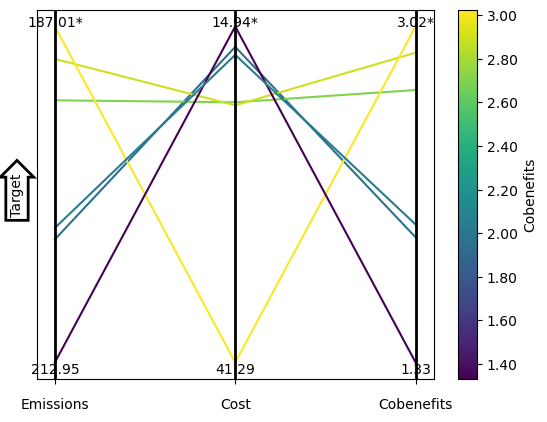

In [14]:
rhodium.parallel_coordinates(rhodium_model, output)
rhodium.plt.show()